This notebook aims at generating a GRU-type model (Gated Recurrent Unit)

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping

Training on data from September 15 to November 15, available at https://open-meteo.com/en/docs/historical-weather-api

Note : we changed the dataset because the model's predictions were biased towards low values, as its training window ended with cold data

In [21]:
filepath = './data/last_year.csv'

df = pd.read_csv(filepath)
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8784 entries, 0 to 8783
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   time         8784 non-null   object 
 1   temperature  8784 non-null   float64
dtypes: float64(1), object(1)
memory usage: 137.4+ KB
None
               time  temperature
0  2024-10-10T00:00         13.9
1  2024-10-10T01:00         12.9
2  2024-10-10T02:00         13.0
3  2024-10-10T03:00         12.6
4  2024-10-10T04:00         12.5


Filter the data set

In [22]:
numeric_cols = ['temperature']
data_selected = df[numeric_cols]
data_selected.shape

(8784, 1)

We fetched hourly data but we needed it half-hourly, so we splitted it as follows :

|hour|°C|
|-|-|
|0|10|
|1|12|
|2|11|

Taking the average values :

|hour|°C|
|-|-|
|0|10|
|0.5|11|
|1|12|
|1.5|11.5|
|2|11|

In [23]:
expanded_data = []

for i in range(len(data_selected) - 1):
    # current value
    expanded_data.append(data_selected.iloc[i].values[0])
    
    # compute and add the average between current and next value
    avg = (data_selected.iloc[i].values[0] + data_selected.iloc[i + 1].values[0]) / 2
    expanded_data.append(avg)

# last value
expanded_data.append(data_selected.iloc[-1].values[0])

data_selected = pd.DataFrame({'temperature': expanded_data})

print(f"New data shape: {data_selected.shape}")
print(data_selected.head(10))

New data shape: (17567, 1)
   temperature
0        13.90
1        13.40
2        12.90
3        12.95
4        13.00
5        12.80
6        12.60
7        12.55
8        12.50
9        12.15


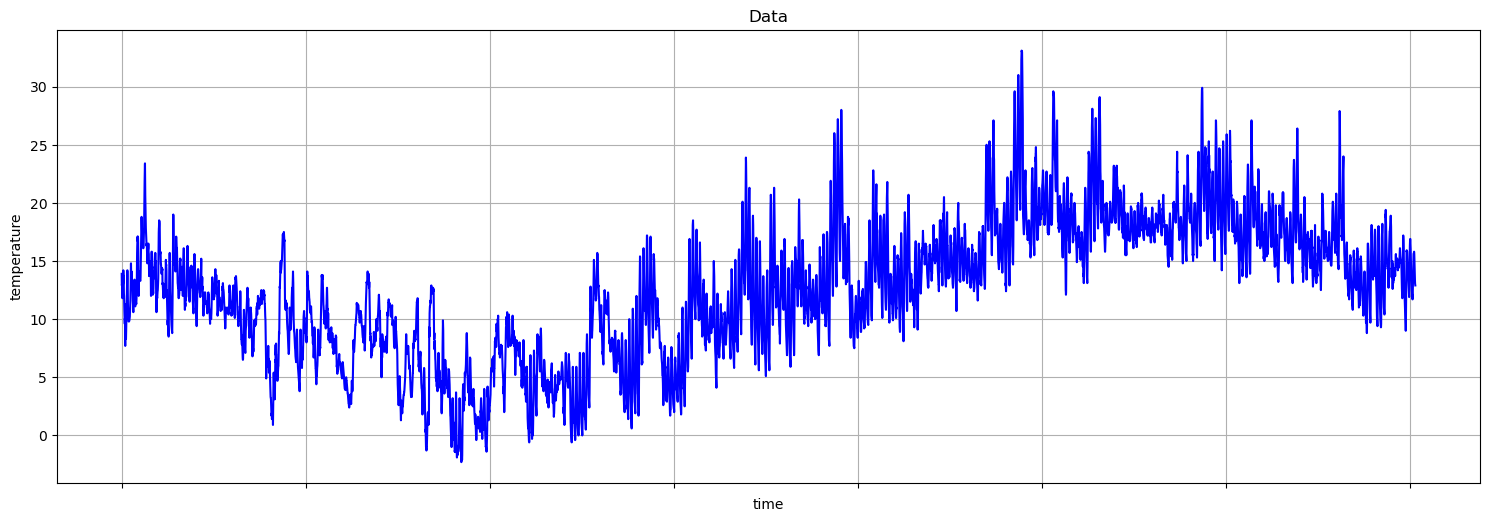

In [24]:
colors = ['blue', 'green']
n_features = len(colors)
plt.figure(figsize=(15, 10))

for i, (feature, color) in enumerate(zip(data_selected.columns, colors), 1):
    ax = plt.subplot(n_features, 1, i, sharex=ax if i > 1 else None)
    data_selected[feature].plot(ax=ax, color=color)
    ax.set_title("Data")
    ax.set_xlabel('time')
    ax.set_ylabel(feature)
    ax.grid(True)

    if i < n_features:
        ax.set_xticklabels([])
    else:
        ax.set_xlabel('Date')

plt.tight_layout()
plt.show()

Split data into train test sets with a ratio of 85%

In [25]:
train_size = int(len(data_selected) * .85)
train_data = data_selected[:train_size]
test_data = data_selected[train_size:]

print(f"Train data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

Train data shape: (14931, 1)
Test data shape: (2636, 1)


Normalize data between 0 and 1

In [26]:
scaler = MinMaxScaler()
scaler.fit([[-5.0], [25.0]])  #here: min=-5°C, max=25°C # 60°   0.2 * 30 = 15 + -5 = 10°

train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

Function to create inputs for our model

In [27]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length)])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

We choose `seq_length` = 48 * 30 min = 24h so that the LSTM can detect daily patterns.

In [28]:
seq_length = 48
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)

In [29]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (14883, 48, 1)
y_train shape: (14883, 1)
X_test shape: (2588, 48, 1)
y_test shape: (2588, 1)


In [30]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Model is quite deep, we tried with several and this one stands out (see [this file](./compare_lstm.ipynb)).

In [31]:
%%capture

model = Sequential([
    GRU(4, input_shape=(seq_length, 1), unroll=True), # Force static unrolling - this is KEY
    Dense(8, activation='relu'),
    Dense(1)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='mse', metrics=['mae'])

Check if the model is light enough for our nano 33

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 4)              │            84 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 133 (532.00 B)

 Trainable params: 133 (532.00 B)

 Non-trainable params: 0 (0.00 B)

We train the model with an `EarlyStopping` in order to detect when training becomes counterproductive (if `val_loss` rises up, we restore the best weights obtained during training).

In [33]:
results = []

history = model.fit(
    X_train, y_train,
    batch_size=16,
    epochs=300,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)],
    verbose=1
    )

Epoch 1/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0061 - mae: 0.0284 - val_loss: 5.1876e-04 - val_mae: 0.0111
Epoch 2/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.0458e-04 - mae: 0.0077 - val_loss: 2.8025e-04 - val_mae: 0.0098
Epoch 3/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.1673e-05 - mae: 0.0063 - val_loss: 2.0856e-04 - val_mae: 0.0067
Epoch 4/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.1654e-05 - mae: 0.0053 - val_loss: 2.0966e-04 - val_mae: 0.0087
Epoch 5/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 5.1983e-05 - mae: 0.0053 - val_loss: 5.7946e-04 - val_mae: 0.0214
Epoch 6/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.9406e-05 - mae: 0.0052 - val_loss: 1.7294e-04 - val_mae: 0.0079
Epoch 7/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.5741e-05 - mae: 0.0050 - val_loss: 1.5523e-04 - val_mae: 0.0054
Epoch 8/300
745/745 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.6764e-05 - mae: 0.0049 - val_loss: 1.4121e-04 - val

In [34]:
test_loss, test_mae = model.evaluate(X_test, y_test)

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3.2744e-05 - mae: 0.0034


Print training history

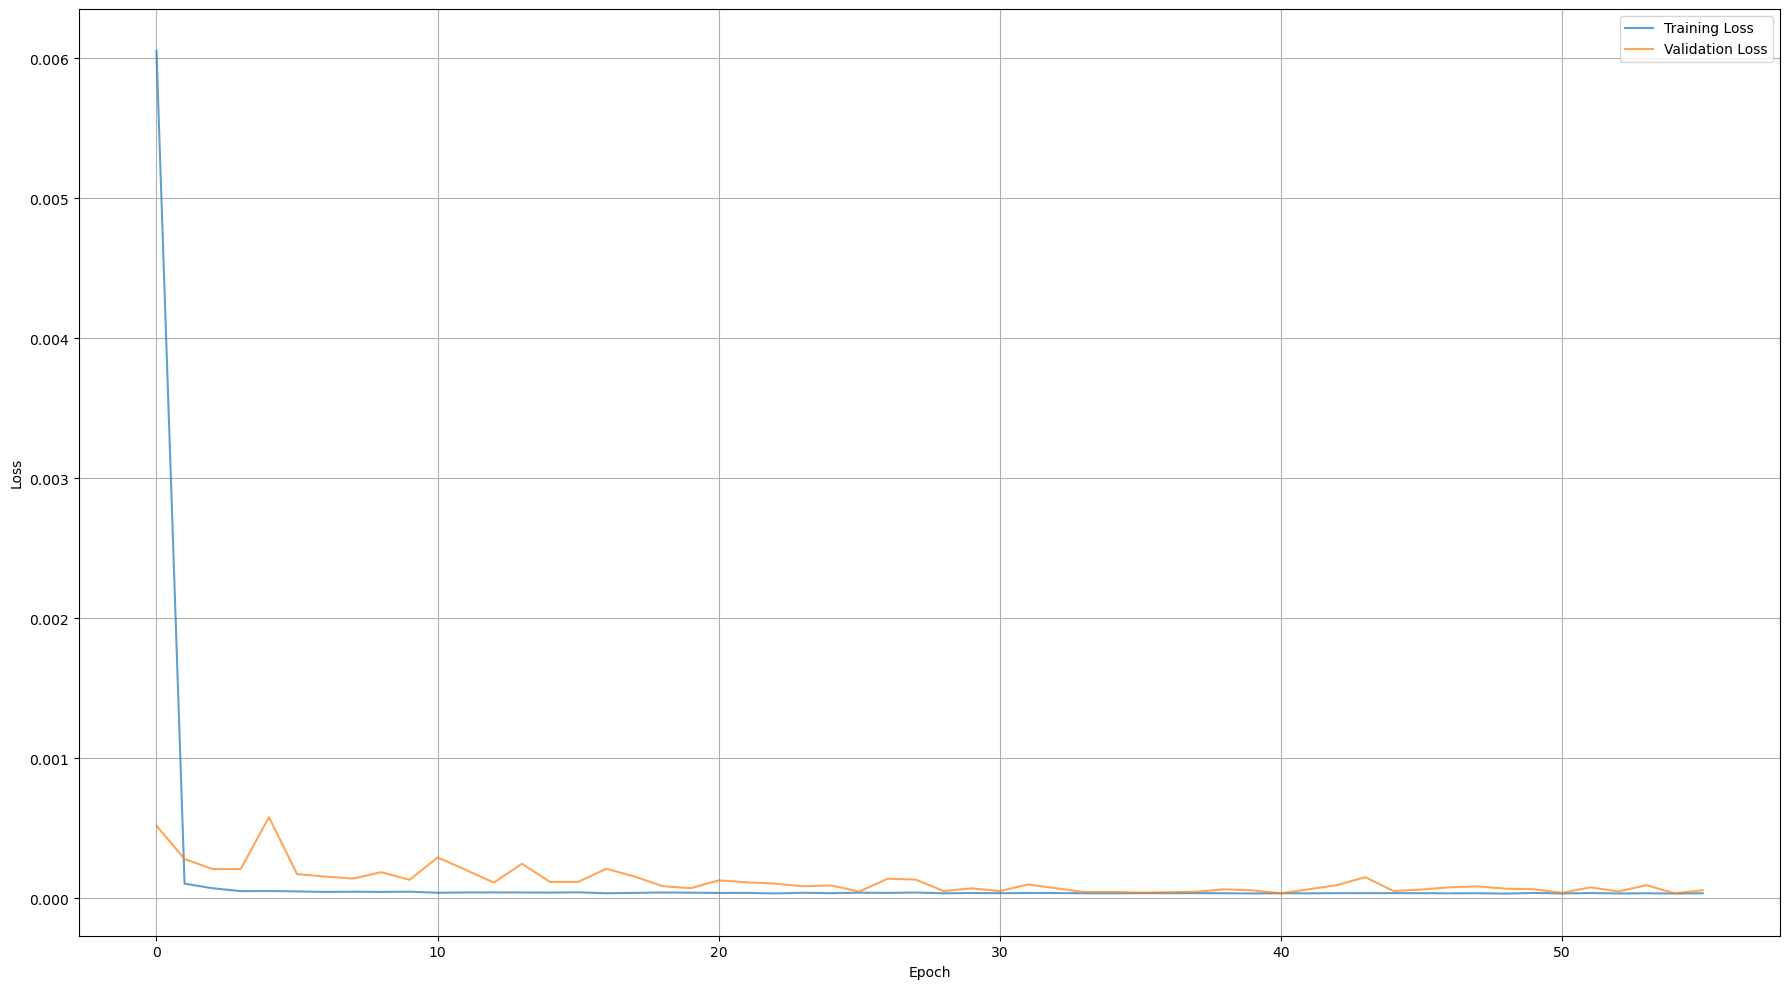

In [35]:
plt.figure(figsize=(18, 10))

plt.plot(history.history['loss'], label='Training Loss', alpha=0.7)
plt.plot(history.history['val_loss'], label='Validation Loss', alpha=0.7)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [36]:
from sklearn.metrics import r2_score

# Make predictions on test set
y_pred = model.predict(X_test, verbose=0)

# Calculate R² score
r2 = r2_score(y_test, y_pred)

print(f"R² Score: {r2:.4f}")
print(f"Test Loss (MSE): {test_loss:.6f}")
print(f"Test MAE: {test_mae:.6f}")

R² Score: 0.9959
Test Loss (MSE): 0.000033
Test MAE: 0.003415


Recursive predictions function : the model feeds with its own last output to predict the next value

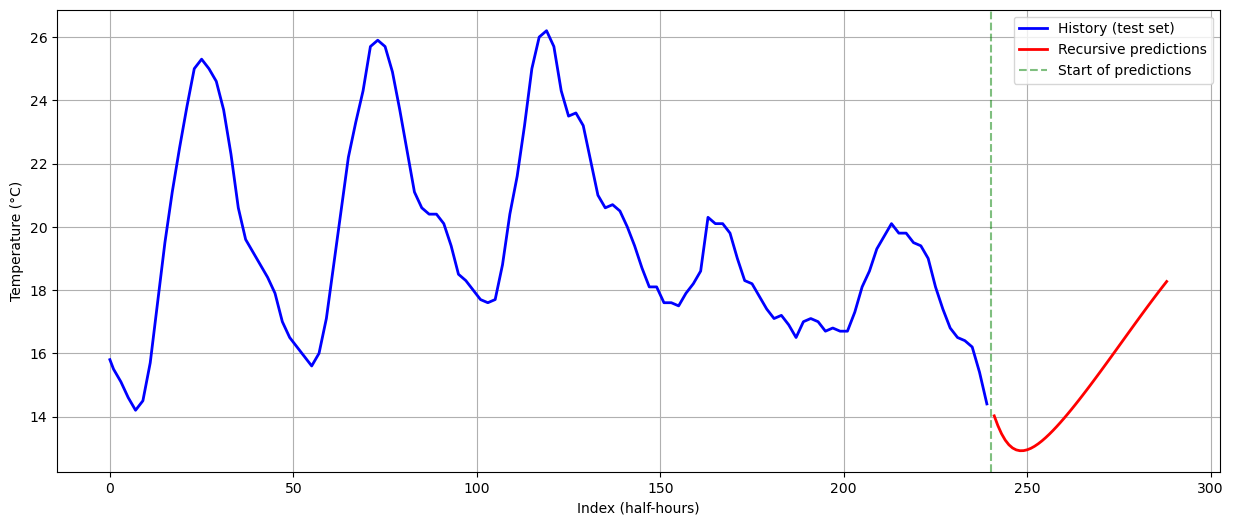

Last value in History: 14.40°C
First prediction: 14.02°C
[14.02318   13.712977  13.456112  13.255456  13.107674  13.006775
 12.946291  12.920131  12.922886  12.949896  12.99722   13.061562
 13.140181  13.230809  13.331575  13.440938  13.557625  13.680583
 13.808946  13.941992  14.079117  14.21981   14.363641  14.510241
 14.659287  14.810494  14.96361   15.118403  15.27466   15.432178
 15.590768  15.750242  15.9104185 16.07112   16.23216   16.393362
 16.55454   16.715508  16.87608   17.036064  17.195269  17.35349
 17.510538  17.666208  17.820295  17.972603  18.122921  18.271055 ]


In [37]:
def predict_recursive(model, initial_sequence, n_steps, scaler):
    current_seq = initial_sequence.copy().reshape(-1, 1)
    predictions = []
    
    for _ in range(n_steps):
        current_input = current_seq.reshape(1, len(current_seq), 1)
        next_pred = model.predict(current_input, verbose=0)[0, 0]
        predictions.append(next_pred)
        current_seq = np.vstack([current_seq[1:], [[next_pred]]])
    
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_denorm = scaler.inverse_transform(predictions).flatten()
    
    return predictions_denorm

n_history = min(240, len(test_scaled))
last_values = test_scaled[:n_history]
last_denorm = scaler.inverse_transform(last_values).flatten()

# start recursive prediction after the displayed values
start_recursive_idx = n_history - seq_length  # ensure the sliding window contains the latest values
initial_sequence = test_scaled[start_recursive_idx:start_recursive_idx + seq_length].flatten()

n_steps = 48
recursive_pred = predict_recursive(model, initial_sequence, n_steps, scaler)

# Display
plt.figure(figsize=(15, 6))
plt.plot(range(n_history), last_denorm, 'b-', label='History (test set)', linewidth=2)
plt.plot(range(n_history + 1, n_history + len(recursive_pred) + 1), recursive_pred, 'r-', label='Recursive predictions', linewidth=2)
plt.axvline(x=n_history, color='green', linestyle='--', alpha=0.5, label='Start of predictions')
plt.xlabel('Index (half-hours)')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.grid(True)
plt.show()

print(f"Last value in History: {last_denorm[-1]:.2f}°C")
print(f"First prediction: {recursive_pred[0]:.2f}°C")
print(recursive_pred)

Save the model

In [38]:
model.save('./models/gru/gru_temperature_model.keras')     # .keras file (native Keras format)
model.save('./models/gru/gru_temperature_model.h5')        # HDF5 file (just in case)

for i, feat in enumerate(numeric_cols):
    print(f"{feat} -> data_min: {scaler.data_min_[i]}, data_max: {scaler.data_max_[i]}, data_range: {scaler.data_range_[i]}")
    print(f"{feat} -> min_: {scaler.min_[i]}, scale_: {scaler.scale_[i]}\n")

print(f"seq_length: {seq_length}")

temperature -> data_min: -2.3, data_max: 33.1, data_range: 35.4
temperature -> min_: 0.06497175141242938, scale_: 0.02824858757062147

seq_length: 48
